# Simulating long experiments

This notebook introduces functionality for simulating experiments over hundreds or even thousands of cycles. 

In [1]:
%pip install pybamm -q
import pybamm
import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.


## Simulating long experiments

In the interest of simplicity and running time, we consider a SPM with SEI effects leading to linear degradation, with parameter values chosen so that the capacity fades by 20% in just a few cycles

In [2]:
parameter_values = pybamm.ParameterValues("Mohtat2020")
parameter_values.update({"SEI kinetic rate constant [m.s-1]": 1e-14})
spm = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited"})

Using the "Electrode SOH" (eSOH) model, we initialize the concentration in each electrode at 100% State of Charge

In [3]:
# Calculate stoichiometries at 100% SOC
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
param = spm.param

Vmin = 3.0
Vmax = 4.2
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)

esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
)
print(f"Initial negative electrode SOC: {esoh_sol['x_100'].data[0]:.3f}")
print(f"Initial positive electrode SOC: {esoh_sol['y_100'].data[0]:.3f}")

# Update parameter values with initial conditions
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": esoh_sol["x_100"].data[0] * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": esoh_sol["y_100"].data[0] * c_p_max,
    }
)

Initial negative electrode SOC: 0.833
Initial positive electrode SOC: 0.034


We can now simulate a single CCCV cycle using the `Experiment` class (see [this notebook](https://github.com/pybamm-team/PyBaMM/blob/develop/examples/notebooks/Getting%20Started/Tutorial%205%20-%20Run%20experiments.ipynb) for more details)

In [4]:
pybamm.set_logging_level("NOTICE")

experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50"
    )
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2021-11-19 15:28:37,539 - [NOTICE] simulation.solve(850): Cycle 1/1 (24.919 ms elapsed) --------------------
2021-11-19 15:28:37,539 - [NOTICE] simulation.solve(884): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:37,582 - [NOTICE] simulation.solve(884): Cycle 1/1, step 2/4: Rest for 1 hour
2021-11-19 15:28:37,614 - [NOTICE] simulation.solve(884): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:37,654 - [NOTICE] simulation.solve(884): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:37,836 - [NOTICE] simulation.solve(990): Finish experiment simulation, took 322.213 ms


Alternatively, we can simulate many CCCV cycles. Here we simulate either 100 cycles or until the capacity is 80% of the initial capacity, whichever is first. The capacity is calculated by the eSOH model

In [5]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
    f"Charge at 1C until {Vmax}V", 
    f"Hold at {Vmax}V until C/50")
] * 500,
termination="80% capacity"
)
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2021-11-19 15:28:39,407 - [NOTICE] simulation.solve(850): Cycle 1/500 (30.887 ms elapsed) --------------------
2021-11-19 15:28:39,408 - [NOTICE] simulation.solve(884): Cycle 1/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:39,484 - [NOTICE] simulation.solve(884): Cycle 1/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:39,587 - [NOTICE] simulation.solve(884): Cycle 1/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:39,832 - [NOTICE] simulation.solve(884): Cycle 1/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:40,361 - [NOTICE] simulation.solve(972): Capacity is now 4.940 Ah (originally 4.940 Ah, will stop at 3.952 Ah)
2021-11-19 15:28:40,361 - [NOTICE] simulation.solve(850): Cycle 2/500 (984.937 ms elapsed) --------------------
2021-11-19 15:28:40,361 - [NOTICE] simulation.solve(884): Cycle 2/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:40,390 - [NOTICE] simulation.solve(884): Cycle 2/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:40,412 - [NO

2021-11-19 15:28:41,558 - [NOTICE] simulation.solve(884): Cycle 13/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:41,594 - [NOTICE] simulation.solve(972): Capacity is now 4.636 Ah (originally 4.940 Ah, will stop at 3.952 Ah)
2021-11-19 15:28:41,594 - [NOTICE] simulation.solve(850): Cycle 14/500 (2.218 s elapsed) --------------------
2021-11-19 15:28:41,594 - [NOTICE] simulation.solve(884): Cycle 14/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:41,616 - [NOTICE] simulation.solve(884): Cycle 14/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:41,635 - [NOTICE] simulation.solve(884): Cycle 14/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:41,655 - [NOTICE] simulation.solve(884): Cycle 14/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:41,688 - [NOTICE] simulation.solve(972): Capacity is now 4.613 Ah (originally 4.940 Ah, will stop at 3.952 Ah)
2021-11-19 15:28:41,689 - [NOTICE] simulation.solve(850): Cycle 15/500 (2.312 s elapsed) --------------------

2021-11-19 15:28:43,214 - [NOTICE] simulation.solve(884): Cycle 26/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:43,261 - [NOTICE] simulation.solve(884): Cycle 26/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:43,293 - [NOTICE] simulation.solve(884): Cycle 26/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:43,342 - [NOTICE] simulation.solve(884): Cycle 26/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:43,412 - [NOTICE] simulation.solve(972): Capacity is now 4.360 Ah (originally 4.940 Ah, will stop at 3.952 Ah)
2021-11-19 15:28:43,413 - [NOTICE] simulation.solve(850): Cycle 27/500 (4.036 s elapsed) --------------------
2021-11-19 15:28:43,413 - [NOTICE] simulation.solve(884): Cycle 27/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:43,456 - [NOTICE] simulation.solve(884): Cycle 27/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:43,482 - [NOTICE] simulation.solve(884): Cycle 27/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:43,508 - [NOT

2021-11-19 15:28:44,898 - [NOTICE] simulation.solve(884): Cycle 38/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:44,930 - [NOTICE] simulation.solve(972): Capacity is now 4.140 Ah (originally 4.940 Ah, will stop at 3.952 Ah)
2021-11-19 15:28:44,931 - [NOTICE] simulation.solve(850): Cycle 39/500 (5.555 s elapsed) --------------------
2021-11-19 15:28:44,931 - [NOTICE] simulation.solve(884): Cycle 39/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:44,951 - [NOTICE] simulation.solve(884): Cycle 39/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:44,970 - [NOTICE] simulation.solve(884): Cycle 39/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:44,988 - [NOTICE] simulation.solve(884): Cycle 39/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:45,021 - [NOTICE] simulation.solve(972): Capacity is now 4.123 Ah (originally 4.940 Ah, will stop at 3.952 Ah)
2021-11-19 15:28:45,021 - [NOTICE] simulation.solve(850): Cycle 40/500 (5.645 s elapsed) --------------------

### Summary variables

We can plot standard variables like the current and voltage, but it isn't very instructive on these timescales

In [6]:
sol.plot(["Current [A]", "Terminal voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=147.01922550864583, step=1.4701922550864583)…

Instead, we plot "summary variables", which show how the battery degrades over time by various metrics. Some of the variables also have "Change in ...", which is how much that variable changes over each cycle. This can be achieved by using `plot_summary_variables` method of pybamm, which can also be used to compare "summary variables" extracted from 2 or more solutions.

In [7]:
sorted(sol.summary_variables.keys())

['C',
 'C_n',
 'C_n * (x_100 - x_0)',
 'C_p',
 'C_p * (y_100 - y_0)',
 'Capacity [A.h]',
 'Change in local ECM resistance [Ohm]',
 'Change in loss of active material in negative electrode [%]',
 'Change in loss of active material in positive electrode [%]',
 'Change in loss of capacity to SEI [A.h]',
 'Change in loss of capacity to lithium plating [A.h]',
 'Change in loss of lithium inventory [%]',
 'Change in loss of lithium inventory, including electrolyte [%]',
 'Change in loss of lithium to SEI [mol]',
 'Change in loss of lithium to lithium plating [mol]',
 'Change in negative electrode capacity [A.h]',
 'Change in positive electrode capacity [A.h]',
 'Change in total capacity lost to side reactions [A.h]',
 'Change in total lithium [mol]',
 'Change in total lithium in electrolyte [mol]',
 'Change in total lithium in negative electrode [mol]',
 'Change in total lithium in particles [mol]',
 'Change in total lithium in positive electrode [mol]',
 'Change in total lithium lost [mol]'

Here the only degradation mechanism is one that causes loss of lithium, so we don't see loss of active material

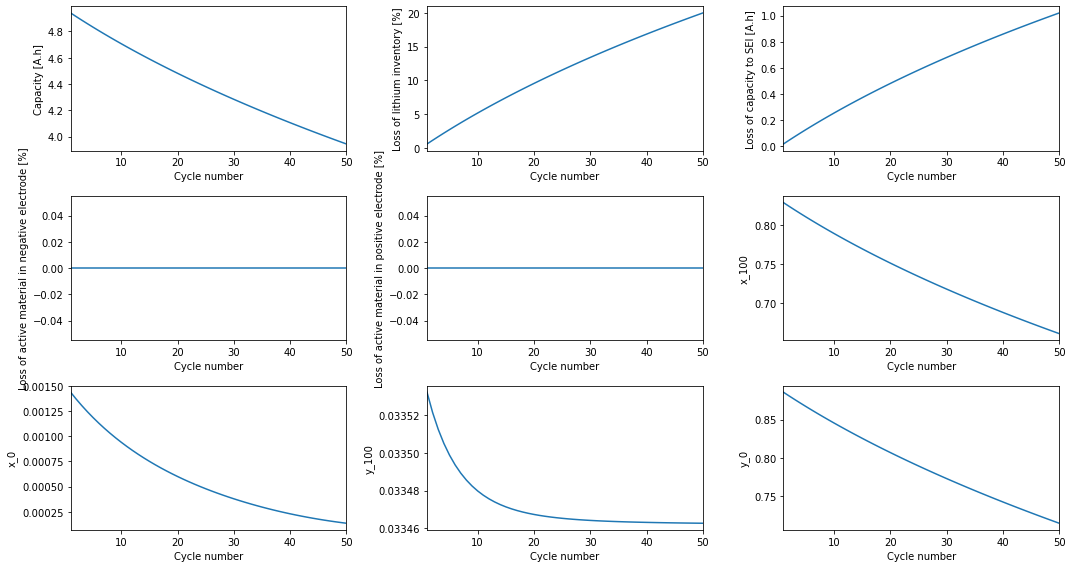

array([[<AxesSubplot:xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='x_100'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='x_0'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='y_100'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [8]:
pybamm.plot_summary_variables(sol)

To suggest additional summary variables, open an issue!

## Choosing which cycles to save

If the simulation contains thousands of cycles, saving each cycle in RAM might not be possible. To get around this, we can use `save_at_cycles`. If this is an integer `n`, every nth cycle is saved. If this is a list, all the cycles in the list are saved.
The first cycle is always saved.

In [9]:
# With integer
sol_int = sim.solve(save_at_cycles=5)
# With list
sol_list = sim.solve(save_at_cycles=[30,45,55])

2021-11-19 15:28:47,257 - [NOTICE] simulation.solve(850): Cycle 1/500 (26.952 ms elapsed) --------------------
2021-11-19 15:28:47,258 - [NOTICE] simulation.solve(884): Cycle 1/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:47,294 - [NOTICE] simulation.solve(884): Cycle 1/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:47,314 - [NOTICE] simulation.solve(884): Cycle 1/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:47,335 - [NOTICE] simulation.solve(884): Cycle 1/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:47,466 - [NOTICE] simulation.solve(972): Capacity is now 3.946 Ah (originally 3.946 Ah, will stop at 3.156 Ah)
2021-11-19 15:28:47,466 - [NOTICE] simulation.solve(850): Cycle 2/500 (236.473 ms elapsed) --------------------
2021-11-19 15:28:47,467 - [NOTICE] simulation.solve(884): Cycle 2/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:47,486 - [NOTICE] simulation.solve(884): Cycle 2/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:47,504 - [NO

2021-11-19 15:28:48,661 - [NOTICE] simulation.solve(884): Cycle 13/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:48,695 - [NOTICE] simulation.solve(972): Capacity is now 3.769 Ah (originally 3.946 Ah, will stop at 3.156 Ah)
2021-11-19 15:28:48,696 - [NOTICE] simulation.solve(850): Cycle 14/500 (1.466 s elapsed) --------------------
2021-11-19 15:28:48,696 - [NOTICE] simulation.solve(884): Cycle 14/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:48,714 - [NOTICE] simulation.solve(884): Cycle 14/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:48,733 - [NOTICE] simulation.solve(884): Cycle 14/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:48,751 - [NOTICE] simulation.solve(884): Cycle 14/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:48,785 - [NOTICE] simulation.solve(972): Capacity is now 3.755 Ah (originally 3.946 Ah, will stop at 3.156 Ah)
2021-11-19 15:28:48,785 - [NOTICE] simulation.solve(850): Cycle 15/500 (1.555 s elapsed) --------------------

2021-11-19 15:28:49,733 - [NOTICE] simulation.solve(884): Cycle 26/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:49,751 - [NOTICE] simulation.solve(884): Cycle 26/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:49,771 - [NOTICE] simulation.solve(884): Cycle 26/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:49,790 - [NOTICE] simulation.solve(884): Cycle 26/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:49,821 - [NOTICE] simulation.solve(972): Capacity is now 3.595 Ah (originally 3.946 Ah, will stop at 3.156 Ah)
2021-11-19 15:28:49,822 - [NOTICE] simulation.solve(850): Cycle 27/500 (2.592 s elapsed) --------------------
2021-11-19 15:28:49,822 - [NOTICE] simulation.solve(884): Cycle 27/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:49,839 - [NOTICE] simulation.solve(884): Cycle 27/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:49,857 - [NOTICE] simulation.solve(884): Cycle 27/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:49,874 - [NOT

2021-11-19 15:28:50,814 - [NOTICE] simulation.solve(884): Cycle 38/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:50,848 - [NOTICE] simulation.solve(972): Capacity is now 3.447 Ah (originally 3.946 Ah, will stop at 3.156 Ah)
2021-11-19 15:28:50,848 - [NOTICE] simulation.solve(850): Cycle 39/500 (3.619 s elapsed) --------------------
2021-11-19 15:28:50,849 - [NOTICE] simulation.solve(884): Cycle 39/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:50,867 - [NOTICE] simulation.solve(884): Cycle 39/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:50,886 - [NOTICE] simulation.solve(884): Cycle 39/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:50,905 - [NOTICE] simulation.solve(884): Cycle 39/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:50,940 - [NOTICE] simulation.solve(972): Capacity is now 3.436 Ah (originally 3.946 Ah, will stop at 3.156 Ah)
2021-11-19 15:28:50,941 - [NOTICE] simulation.solve(850): Cycle 40/500 (3.711 s elapsed) --------------------

2021-11-19 15:28:51,847 - [NOTICE] simulation.solve(884): Cycle 51/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:51,865 - [NOTICE] simulation.solve(884): Cycle 51/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:51,883 - [NOTICE] simulation.solve(884): Cycle 51/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:51,899 - [NOTICE] simulation.solve(884): Cycle 51/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:51,936 - [NOTICE] simulation.solve(972): Capacity is now 3.301 Ah (originally 3.946 Ah, will stop at 3.156 Ah)
2021-11-19 15:28:51,936 - [NOTICE] simulation.solve(850): Cycle 52/500 (4.706 s elapsed) --------------------
2021-11-19 15:28:51,936 - [NOTICE] simulation.solve(884): Cycle 52/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:51,952 - [NOTICE] simulation.solve(884): Cycle 52/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:51,970 - [NOTICE] simulation.solve(884): Cycle 52/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:51,986 - [NOT

2021-11-19 15:28:52,884 - [NOTICE] simulation.solve(884): Cycle 63/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:52,915 - [NOTICE] simulation.solve(972): Capacity is now 3.177 Ah (originally 3.946 Ah, will stop at 3.156 Ah)
2021-11-19 15:28:52,916 - [NOTICE] simulation.solve(850): Cycle 64/500 (5.686 s elapsed) --------------------
2021-11-19 15:28:52,916 - [NOTICE] simulation.solve(884): Cycle 64/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:52,935 - [NOTICE] simulation.solve(884): Cycle 64/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:52,953 - [NOTICE] simulation.solve(884): Cycle 64/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:52,968 - [NOTICE] simulation.solve(884): Cycle 64/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:53,004 - [NOTICE] simulation.solve(972): Capacity is now 3.167 Ah (originally 3.946 Ah, will stop at 3.156 Ah)
2021-11-19 15:28:53,004 - [NOTICE] simulation.solve(850): Cycle 65/500 (5.775 s elapsed) --------------------

2021-11-19 15:28:54,054 - [NOTICE] simulation.solve(850): Cycle 10/500 (885.735 ms elapsed) --------------------
2021-11-19 15:28:54,054 - [NOTICE] simulation.solve(884): Cycle 10/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:54,074 - [NOTICE] simulation.solve(884): Cycle 10/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:54,094 - [NOTICE] simulation.solve(884): Cycle 10/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:54,115 - [NOTICE] simulation.solve(884): Cycle 10/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:54,150 - [NOTICE] simulation.solve(972): Capacity is now 3.071 Ah (originally 3.149 Ah, will stop at 2.519 Ah)
2021-11-19 15:28:54,151 - [NOTICE] simulation.solve(850): Cycle 11/500 (982.614 ms elapsed) --------------------
2021-11-19 15:28:54,152 - [NOTICE] simulation.solve(884): Cycle 11/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:54,172 - [NOTICE] simulation.solve(884): Cycle 11/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:54,

2021-11-19 15:28:55,120 - [NOTICE] simulation.solve(884): Cycle 22/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:55,133 - [NOTICE] simulation.solve(884): Cycle 22/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:55,164 - [NOTICE] simulation.solve(972): Capacity is now 2.988 Ah (originally 3.149 Ah, will stop at 2.519 Ah)
2021-11-19 15:28:55,165 - [NOTICE] simulation.solve(850): Cycle 23/500 (1.997 s elapsed) --------------------
2021-11-19 15:28:55,165 - [NOTICE] simulation.solve(884): Cycle 23/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:55,180 - [NOTICE] simulation.solve(884): Cycle 23/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:55,199 - [NOTICE] simulation.solve(884): Cycle 23/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:55,213 - [NOTICE] simulation.solve(884): Cycle 23/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:55,244 - [NOTICE] simulation.solve(972): Capacity is now 2.982 Ah (originally 3.149 Ah, will stop at 2.519 Ah)
202

2021-11-19 15:28:56,150 - [NOTICE] simulation.solve(850): Cycle 35/500 (2.982 s elapsed) --------------------
2021-11-19 15:28:56,150 - [NOTICE] simulation.solve(884): Cycle 35/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:56,168 - [NOTICE] simulation.solve(884): Cycle 35/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:56,188 - [NOTICE] simulation.solve(884): Cycle 35/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:56,207 - [NOTICE] simulation.solve(884): Cycle 35/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:56,247 - [NOTICE] simulation.solve(972): Capacity is now 2.915 Ah (originally 3.149 Ah, will stop at 2.519 Ah)
2021-11-19 15:28:56,247 - [NOTICE] simulation.solve(850): Cycle 36/500 (3.079 s elapsed) --------------------
2021-11-19 15:28:56,247 - [NOTICE] simulation.solve(884): Cycle 36/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:56,265 - [NOTICE] simulation.solve(884): Cycle 36/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:56,284 - 

2021-11-19 15:28:57,225 - [NOTICE] simulation.solve(884): Cycle 47/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:57,241 - [NOTICE] simulation.solve(884): Cycle 47/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:57,276 - [NOTICE] simulation.solve(972): Capacity is now 2.847 Ah (originally 3.149 Ah, will stop at 2.519 Ah)
2021-11-19 15:28:57,277 - [NOTICE] simulation.solve(850): Cycle 48/500 (4.109 s elapsed) --------------------
2021-11-19 15:28:57,278 - [NOTICE] simulation.solve(884): Cycle 48/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:57,295 - [NOTICE] simulation.solve(884): Cycle 48/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:57,315 - [NOTICE] simulation.solve(884): Cycle 48/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:57,331 - [NOTICE] simulation.solve(884): Cycle 48/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:57,365 - [NOTICE] simulation.solve(972): Capacity is now 2.841 Ah (originally 3.149 Ah, will stop at 2.519 Ah)
202

2021-11-19 15:28:58,306 - [NOTICE] simulation.solve(850): Cycle 60/500 (5.138 s elapsed) --------------------
2021-11-19 15:28:58,307 - [NOTICE] simulation.solve(884): Cycle 60/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:58,322 - [NOTICE] simulation.solve(884): Cycle 60/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:58,342 - [NOTICE] simulation.solve(884): Cycle 60/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:58,355 - [NOTICE] simulation.solve(884): Cycle 60/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:58,394 - [NOTICE] simulation.solve(972): Capacity is now 2.765 Ah (originally 3.149 Ah, will stop at 2.519 Ah)
2021-11-19 15:28:58,395 - [NOTICE] simulation.solve(850): Cycle 61/500 (5.226 s elapsed) --------------------
2021-11-19 15:28:58,395 - [NOTICE] simulation.solve(884): Cycle 61/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:58,411 - [NOTICE] simulation.solve(884): Cycle 61/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:58,430 - 

2021-11-19 15:28:59,463 - [NOTICE] simulation.solve(884): Cycle 72/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:59,481 - [NOTICE] simulation.solve(884): Cycle 72/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:59,523 - [NOTICE] simulation.solve(972): Capacity is now 2.682 Ah (originally 3.149 Ah, will stop at 2.519 Ah)
2021-11-19 15:28:59,524 - [NOTICE] simulation.solve(850): Cycle 73/500 (6.356 s elapsed) --------------------
2021-11-19 15:28:59,524 - [NOTICE] simulation.solve(884): Cycle 73/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:28:59,543 - [NOTICE] simulation.solve(884): Cycle 73/500, step 2/4: Rest for 1 hour
2021-11-19 15:28:59,563 - [NOTICE] simulation.solve(884): Cycle 73/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:28:59,581 - [NOTICE] simulation.solve(884): Cycle 73/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:28:59,620 - [NOTICE] simulation.solve(972): Capacity is now 2.675 Ah (originally 3.149 Ah, will stop at 2.519 Ah)
202

2021-11-19 15:29:00,637 - [NOTICE] simulation.solve(850): Cycle 85/500 (7.468 s elapsed) --------------------
2021-11-19 15:29:00,637 - [NOTICE] simulation.solve(884): Cycle 85/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:29:00,652 - [NOTICE] simulation.solve(884): Cycle 85/500, step 2/4: Rest for 1 hour
2021-11-19 15:29:00,672 - [NOTICE] simulation.solve(884): Cycle 85/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:29:00,684 - [NOTICE] simulation.solve(884): Cycle 85/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:29:00,723 - [NOTICE] simulation.solve(972): Capacity is now 2.593 Ah (originally 3.149 Ah, will stop at 2.519 Ah)
2021-11-19 15:29:00,724 - [NOTICE] simulation.solve(850): Cycle 86/500 (7.555 s elapsed) --------------------
2021-11-19 15:29:00,724 - [NOTICE] simulation.solve(884): Cycle 86/500, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:29:00,738 - [NOTICE] simulation.solve(884): Cycle 86/500, step 2/4: Rest for 1 hour
2021-11-19 15:29:00,757 - 

2021-11-19 15:29:01,760 - [NOTICE] simulation.solve(884): Cycle 97/500, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:29:01,774 - [NOTICE] simulation.solve(884): Cycle 97/500, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:29:01,939 - [NOTICE] simulation.solve(978): Stopping experiment since capacity (2.514 Ah) is below stopping capacity (2.519 Ah).
2021-11-19 15:29:01,941 - [NOTICE] simulation.solve(990): Finish experiment simulation, took 8.773 s


In [10]:
sol_int.cycles

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [11]:
sol_list.cycles

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

For the cycles that are saved, you can plot as usual (note off-by-1 indexing)

In [12]:
sol_list.cycles[44].plot(["Current [A]","Terminal voltage [V]"])

interactive(children=(FloatSlider(value=104.91777482952412, description='t', max=107.27032274825723, min=104.9…

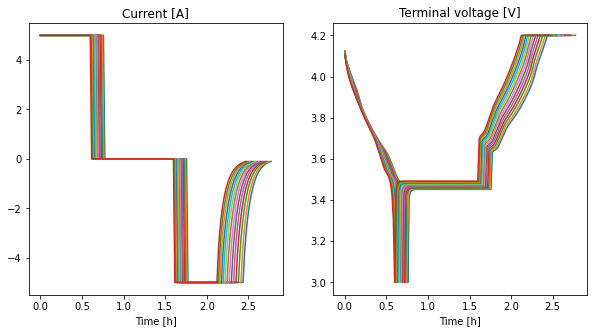

In [13]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
for cycle in sol_int.cycles:
    if cycle is not None:
        t = cycle["Time [h]"].data - cycle["Time [h]"].data[0]
        ax[0].plot(t, cycle["Current [A]"].data)
        ax[0].set_xlabel("Time [h]")
        ax[0].set_title("Current [A]")
        ax[1].plot(t, cycle["Terminal voltage [V]"].data)
        ax[1].set_xlabel("Time [h]")
        ax[1].set_title("Terminal voltage [V]")

All summary variables are always available for every cycle, since these are much less memory-intensive

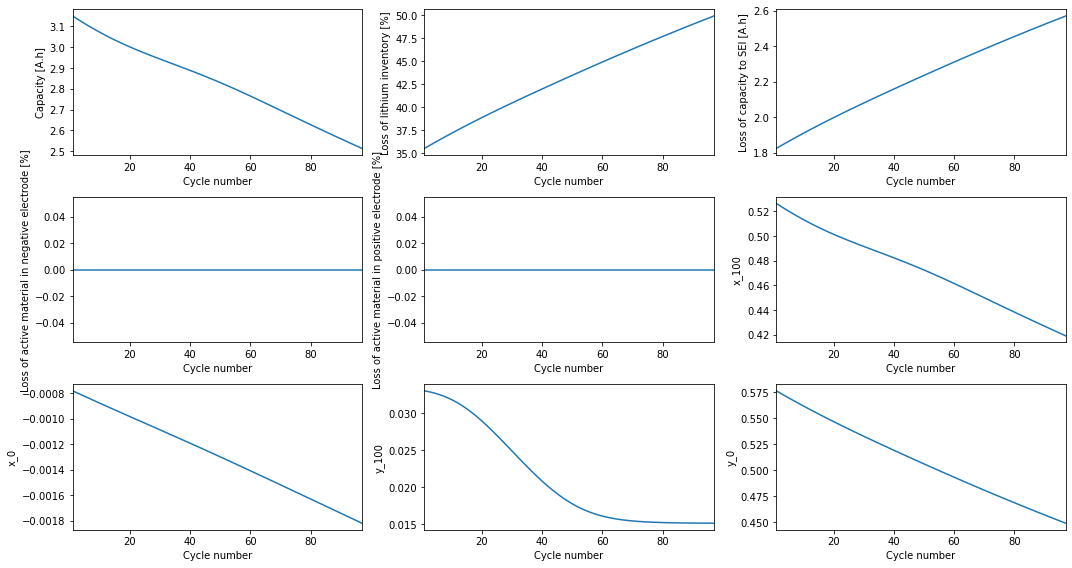

array([[<AxesSubplot:xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='x_100'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='x_0'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='y_100'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [14]:
pybamm.plot_summary_variables(sol_list)

## Starting solution

A simulation can be performed iteratively by using the `starting_solution` feature. For example, we first solve for 10 cycles

In [15]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
    f"Charge at 1C until {Vmax}V", 
    f"Hold at {Vmax}V until C/50")
] * 10,
termination="80% capacity"
)
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2021-11-19 15:29:04,352 - [NOTICE] simulation.solve(850): Cycle 1/10 (24.739 ms elapsed) --------------------
2021-11-19 15:29:04,352 - [NOTICE] simulation.solve(884): Cycle 1/10, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:29:04,391 - [NOTICE] simulation.solve(884): Cycle 1/10, step 2/4: Rest for 1 hour
2021-11-19 15:29:04,424 - [NOTICE] simulation.solve(884): Cycle 1/10, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:29:04,463 - [NOTICE] simulation.solve(884): Cycle 1/10, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:29:04,633 - [NOTICE] simulation.solve(972): Capacity is now 4.940 Ah (originally 4.940 Ah, will stop at 3.952 Ah)
2021-11-19 15:29:04,634 - [NOTICE] simulation.solve(850): Cycle 2/10 (306.843 ms elapsed) --------------------
2021-11-19 15:29:04,634 - [NOTICE] simulation.solve(884): Cycle 2/10, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:29:04,657 - [NOTICE] simulation.solve(884): Cycle 2/10, step 2/4: Rest for 1 hour
2021-11-19 15:29:04,675 - [NOTICE] si

If we give `sol` as the starting solution this will then solve for the next 10 cycles

In [16]:
sol2 = sim.solve(starting_solution=sol)

2021-11-19 15:29:05,527 - [NOTICE] simulation.solve(850): Cycle 11/20 (26.183 ms elapsed) --------------------
2021-11-19 15:29:05,528 - [NOTICE] simulation.solve(884): Cycle 11/20, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:29:05,553 - [NOTICE] simulation.solve(884): Cycle 11/20, step 2/4: Rest for 1 hour
2021-11-19 15:29:05,571 - [NOTICE] simulation.solve(884): Cycle 11/20, step 3/4: Charge at 1C until 4.2V
2021-11-19 15:29:05,595 - [NOTICE] simulation.solve(884): Cycle 11/20, step 4/4: Hold at 4.2V until C/50
2021-11-19 15:29:05,939 - [NOTICE] simulation.solve(972): Capacity is now 4.682 Ah (originally 4.940 Ah, will stop at 3.952 Ah)
2021-11-19 15:29:05,939 - [NOTICE] simulation.solve(850): Cycle 12/20 (438.580 ms elapsed) --------------------
2021-11-19 15:29:05,940 - [NOTICE] simulation.solve(884): Cycle 12/20, step 1/4: Discharge at 1C until 3.0V
2021-11-19 15:29:05,963 - [NOTICE] simulation.solve(884): Cycle 12/20, step 2/4: Rest for 1 hour
2021-11-19 15:29:05,980 - [NO

We have now simulated 20 cycles

In [17]:
len(sol2.cycles)

20

## References

The relevant papers for this notebook are:

In [18]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Scott G. Marquis, Valentin Sulzer, Robert Timms, Colin P. Please, and S. Jon Chapman. An asymptotic derivation of a single particle model with electrolyte. Journal of The Electrochemical Society, 166(15):A3693–A3706, 2019. doi:10.1149/2.0341915jes.
[4] Peyman Mohtat, Suhak Lee, Jason B Siegel, and Anna G Stefanopoulou. Towards better estimability of electrode-specific state of health: decoding the cell expansion. Journal of Power Sources, 427:101–111, 201